# **Analyzing Tech Salaries in Different Countries: Investigating Influential Factors**

# Project One

## Introduction
This research project explores variations and factors affecting tech salaries between different countries, leveraging a dataset from results of a 2016 Hacker News survey about salaries and bonuses. 

The data is obtained from [Kaggle Notebook](https://www.kaggle.com/datasets/thedevastator/know-your-worth-tech-salaries-in-2016), original source by Brandon Telle [[source]](https://data.world/brandon-telle/2016-hacker-news-salary-survey-results). This dataset includes details about salaries in the tech industry in 2016, including information such as employer names, locations, job titles, experience levels, and compensation details. 

The primary focus of this reserach is on analyzing the disparities in salaries across different locations internationally and understanding the potential factors influencing these variations. The research question guiding this investigation is: "How do salaries in the tech industry vary between different countries, and what factors contribute to these variations?" By analyzing this dataset, I aim to uncover patterns and correlations between salary and associated variables that can contribute to a more nuanced understanding of compensation trends within the tech sector.

Dependent variable (Y): Annual base pay is set to be the dependent variable. 

- *annual_base_pay*: The annual base pay is the fixed yearly salary, excluding any additional bonuses or benefits. It serves as the dependent variable in my analysis because it representes the core earnings of the respondent and is a key metric in understanding the global tech salary landscape. This allows me to analyze salary trends and factors influencing salary disparities.

Independent variables (X): The following variables are set to be the independent variables: job category, employer name, and job title. These chosen independent variables collectively provide a comprehensive view of factors influencing annual base pay in the tech industry, directly addressing my research question on the variations in salaries between cities and the underlying factors contributing to these variations.

- *location_country*: The location_country variable represents the country in which the respondent is employed. This variable is essential for understanding salary disparities across different regions and countries. Economic conditions, cost of living, and market demand for tech professionals vary greatly between countries, which directly influences salary levels. Including location_country as an independent variable allows for the analysis of how geographical location impacts annual base pay within the tech industry, directly addressing the research question on variations in tech salaries between different countries.
- *employer_name*: The reputation and financial capabilities of the employer can influence salary levels. Larger, more established companies might offer higher salaries compared to smaller startups. Including employer_name as an independent variable allows me to explore the relationship between the reputation or size of the employer and the annual base pay received by the respondents. This adds a corporate dimension to my analysis, investigating how company reputation and stature affect compensation.
- *job_title_category*: The nature of the job, whether it's a software, data, engineering, or management can influence the salary level. Categorizing job roles helps examine how distinct fields in the tech industry contribute to salary variations. This variable is crucial for analysis as I seek to understand the impact of job categories on annual base pay.
- *total_experience_years*: The total number of years of professional experience the respondent has accumulated is an expected influencing factor on salary because individuals with more experience tend to command higher pay due to their acquired skills, expertise, and experience in the industry. Examining the experience level can reflect the market value of an individual's expertise in different locations, providing a more comprehensive understanding of the dynamics influencing compensation in the tech industry.
- *annual_bonus*: Annual bonus captures the impact of variable compensation on the overall annual salary of the respondent. Analyzing the relationship between annual bonuses and annual base pay allows for a more holistic understanding of the factors influencing salary variations in the tech industry. Assessing the difference in annual bonus for individuals with similar base salaries provides insights into the reward structures and performance-based incentives prevalent in different countries. Analyzing the presence and magnitude of annual bonuses can provide insights into the overall compensation offered by employers and their impact on salary differentials across locations.

## Data Cleaning/Loading

In [231]:
import pandas as pd
import geopandas as gpd

import geopy.geocoders
from geopy.geocoders import GoogleV3
import certifi
import ssl

from shapely.geometry import Point

import pycountry

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import warnings

from Config import api_key

%matplotlib inline

In [173]:
#load in dataset
df = pd.read_csv("~/ECO225/ECO225Project/Data/salaries_cleaning.csv", low_memory=False)
df.head()

,index,salary_id,employer_name,location_name,location_state,location_country,location_latitude,location_longitude,job_title,job_title_category,job_title_rank,total_experience_years,employer_experience_years,annual_base_pay,signing_bonus,annual_bonus,stock_value_bonus,comments,submitted_at
0,0,1,opower,"san francisco, ca",CA,US,37.77,-122.41,systems engineer,Engineering,NaN,13.0,2.0,125000.0,5000.0,0.0,5000 shares,Don't work here.,3/21/16 12:58
1,1,3,walmart,"bentonville, ar",AR,US,36.36,-94.20,senior developer,Software,Senior,15.0,8.0,65000.0,NaN,5000.0,"3,000",NaN,3/21/16 12:58
2,2,4,vertical knowledge,"cleveland, oh",OH,US,41.47,-81.67,software engineer,Software,NaN,4.0,1.0,86000.0,5000.0,6000.0,0,NaN,3/21/16 12:59
3,3,6,netapp,waltham,MA,US,NaN,NaN,mts,Other,NaN,4.0,0.0,105000.0,5000.0,8500.0,0,NaN,3/21/16 13:00
4,4,12,apple,cupertino,CA,US,NaN,NaN,software engineer,Software,NaN,4.0,3.0,110000.0,5000.0,7000.0,150000,NaN,3/21/16 13:02


In [3]:
#drop unneeded columns
cleaned_df = df.drop(columns=['index', "salary_id", "job_title_rank", 'employer_experience_years', "signing_bonus", "stock_value_bonus", "comments", "submitted_at"])

#display percentage of missing data (null value) in each column: number of NaNs/total number of index
round(100*(cleaned_df.isnull().sum()/len(cleaned_df.index)), 2)

employer_name              0.24
location_name              0.00
location_state            30.39
location_country           4.41
location_latitude         49.79
location_longitude        49.79
job_title                  0.00
job_title_category         0.00
total_experience_years     2.84
annual_base_pay            0.24
annual_bonus              19.27
dtype: float64

In [4]:
#drop rows that have missing values for annual base pay, employer, total_experience_years and location_country
cleaned_df.dropna(subset=['employer_name', 'annual_base_pay', 'total_experience_years', 'location_country'], inplace=True)

#drop duplicate entries
cleaned_df = cleaned_df.drop_duplicates(subset=['employer_name', 'location_name', 'location_state', 'location_country', 'location_latitude', 'location_longitude', 'job_title', 'job_title_category', 'total_experience_years', 'annual_base_pay', 'annual_bonus'])

#reset index
cleaned_df.reset_index(drop=True, inplace=True)

#replace missing values in annual_bonus with 0
cleaned_df['annual_bonus'] = cleaned_df['annual_bonus'].fillna(value=0)

In [25]:
#get latitude and longitude from city and country
cleaned_df['location_name'] = cleaned_df['location_name'].str.split(',').str[0]
ctx = ssl.create_default_context(cafile=certifi.where())
geopy.geocoders.options.default_ssl_context = ctx

def get_lat_long(row):
    city = row['location_name']
    country = row['location_country']
    geolocator = GoogleV3(api_key = api_key)
    location = geolocator.geocode(f"{city}, {country}")
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

In [89]:
cleaned_df[['location_latitude', 'location_longitude']] = cleaned_df.apply(get_lat_long, axis=1, result_type='expand')
cleaned_df.to_csv("salaries_cleaned.csv")

In [28]:
#load in exchange_rates dataset
exchange_rates_df = pd.read_csv("/Users/macychen/ECO225/ECO225Project/Data/exchange_rates_2016.csv", low_memory=False)
cleanedrates_df = exchange_rates_df.drop(columns=['INDICATOR', "SUBJECT", "MEASURE", "FREQUENCY", "TIME", "Flag Codes"])
cleanedrates_df['Value'] = cleanedrates_df['Value'].astype(float)

cleanedrates_df.head()

,LOCATION,Value
0,AUS,1.345214
1,AUT,0.903421
2,BEL,0.903421
3,CAN,1.325615
4,CZE,24.439917


In [192]:
# Create a dictionary to map country to exchange rate
exchange_rate_dict = dict(zip(cleanedrates_df['LOCATION'], cleanedrates_df['Value']))

converted_cleaned_df = pd.read_csv("/Users/macychen/ECO225/ECO225Project/Data/salaries_cleaned.csv", low_memory=False)
converted_cleaned_df['location_country'] = [pycountry.countries.get(alpha_2=code).alpha_3 for code in converted_cleaned_df['location_country']]

# Multiply salary and bonus by the exchange rate using map
converted_cleaned_df['annual_bonus'] = (1/converted_cleaned_df['location_country'].map(exchange_rate_dict)) * converted_cleaned_df['annual_bonus']
converted_cleaned_df['annual_base_pay'] = (1/converted_cleaned_df['location_country'].map(exchange_rate_dict)) * converted_cleaned_df['annual_base_pay']

converted_cleaned_df['annual_bonus'] = converted_cleaned_df['annual_bonus'].fillna(value=0)

converted_cleaned_df

,employer_name,location_name,location_state,location_country,location_latitude,location_longitude,job_title,job_title_category,total_experience_years,annual_base_pay,annual_bonus
0,opower,san francisco,CA,USA,37.774929,-122.419415,systems engineer,Engineering,13.0,125000.0,0.0
1,walmart,bentonville,AR,USA,36.372356,-94.210214,senior developer,Software,15.0,65000.0,5000.0
2,vertical knowledge,cleveland,OH,USA,41.499320,-81.694361,software engineer,Software,4.0,86000.0,6000.0
3,netapp,waltham,MA,USA,42.376485,-71.235611,mts,Other,4.0,105000.0,8500.0
4,apple,cupertino,CA,USA,37.322998,-122.032182,software engineer,Software,4.0,110000.0,7000.0
...,...,...,...,...,...,...,...,...,...,...,...
1524,mainz brady group - contractor at nike,beaverton,OR,USA,45.486928,-122.804032,front-end developer,Web,2.0,50.0,0.0
1525,sparkfun electronics,boulder,CO,USA,40.014986,-105.270546,junior software developer,Software,1.0,60500.0,800.0
1526,$2bn valuation tech company,new york city,NY,USA,40.712775,-74.005973,sr. frontend eng,Web,7.0,150000.0,0.0
1527,of maryland,college park,MD,USA,38.989697,-76.937760,scientific programmer (faculty research assist...,Applied Science,5.0,75000.0,0.0


## Summary Statistics Tables

In [30]:
summary_columns = converted_cleaned_df.drop(['location_latitude', 'location_longitude'], axis=1).columns
converted_cleaned_df[summary_columns].describe()

,total_experience_years,annual_base_pay,annual_bonus
count,1529.000000,1.529000e+03,1529.000000
mean,6.598973,1.093013e+05,7055.629494
std,5.295760,3.581698e+05,27459.012791
min,0.000000,0.000000e+00,0.000000
25%,3.000000,5.800000e+04,0.000000
50%,5.000000,9.407886e+04,0.000000
75%,10.000000,1.260000e+05,6750.972815
max,40.000000,1.028000e+07,750000.000000


The summary statistics table provides valuable insights into quantitative variables associated with salaries. The average total experience (mean) is approximately 6.6 years, with the standard deviation at 5.3 years. The minimum of 0 years suggests the presence of respondents with minimal experience in the industry, while the maximum is at 40 years. This notable range in standard deviation and between maximum and minimum experience years indicaztes a diverse set of experience levels within the respondents of the survey. 

The average annual base pay is 109,301.3 USD, but the high standard deviation of 358,169.8 USD indicates substantial salary variability. Notably, some entries report no base pay, and there is a wide range of salaries, including potential outliers with extremely high values. Whether this is related to the wide range of experience years can be explored later in my research. 

The annual bonus, with a mean of 7,055.6 USD and a significant standard deviation of 27,459.0 USD, reveals wide-ranging bonus amounts, and a substantial proportion of individuals do not receive a bonus, as indicated by the 25th and 50th percentiles that are 0 USD. Similar to annual base pay, the difference between the maximum and minimum annual bonus recorded is also very large, which could indicate potential outliers as well. 

For the research question on salary variations in the tech industry and contributing factors, attention will be given to outliers in annual base pay and bonus, and further exploration is warranted to understand the distribution. I plan to explore factors contributing to this variation, such as experience level, job category and employer. While additional data exploration and statistical analysis are needed to draw more robust conclusions about the factors influencing salary variation, this summary statistics table provide a foundation for more in-depth analysis and indications to areas of interest that may influence salary. 

In [31]:
converted_cleaned_df.describe(include=['object'])

,employer_name,location_name,location_state,location_country,job_title,job_title_category
count,1529,1529,1112,1529,1529,1529
unique,989,446,50,61,614,8
top,google,san francisco,CA,USA,software engineer,Software
freq,60,168,412,1079,291,834


This summary statistics table presents a snapshot of the qualitative variables related to tech industry jobs across different employers and locations. With a total of 1,529 entries after cleaning, the dataset encompasses a diverse range of 989 unique employer names, highlighting the diversity of employers in the tech industry. Google emerges as the most frequently mentioned employer, appearing 60 times, indicating its prominence in the dataset. This invites investigation into whether salary contributes to the popularity of an employer, particularly given Google and its significance in the tech job landscape. 

While 61 unique countries are covered in this dataset, the United States (US) dominates with 1,079 occurrences. This represents that the majority of respondents work in the US, with San Francisco, California being the common. This finding aligns with the United States being known a global leader in the technology industry, with the well-known concentration of tech companies and innovation hubs in the broader California region. 

In terms of job titles, "Software Engineer" stands out as the most frequently occurring title at 291 times. In line with this result, out of the eight job categories available (engineering, software, web, data, management, operations, applied science, other), "Software" is most commonly worked in, appearing 834 times. This high popularity in software-related jobs likely results in higher competition in this category, and its effect on annual salary is an area of exploration for my research. 

## Plots, Histograms, Figures

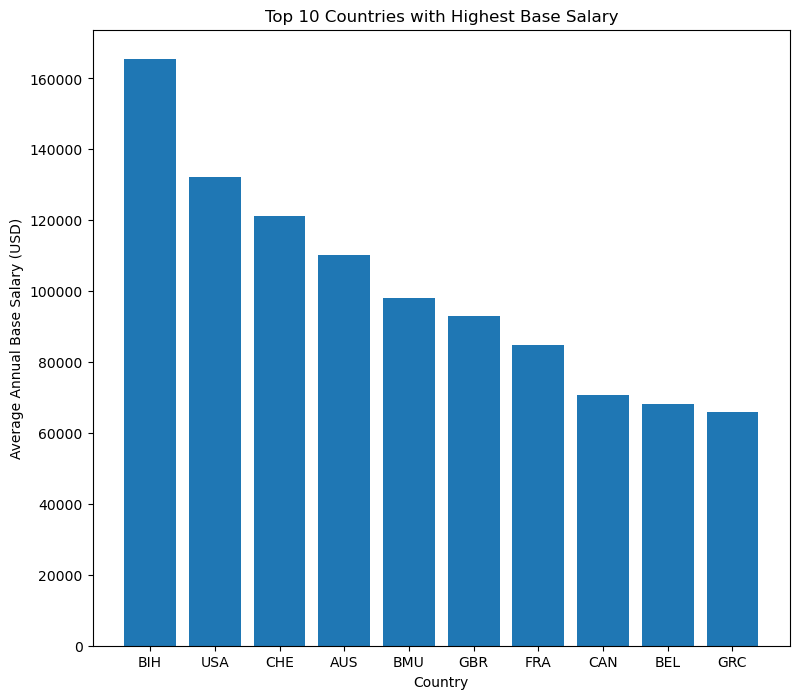

In [250]:
# Group by country and calculate the mean salary
countrygrouped_df = converted_cleaned_df.groupby('location_country')['annual_base_pay'].mean().reset_index()

# Sort by mean salary in descending order and select the top 10
top_countries = countrygrouped_df.sort_values(by='annual_base_pay', ascending=False).head(10)

plt.figure(figsize=(9, 8))

plt.bar(top_countries['location_country'], top_countries['annual_base_pay'])
plt.title('Top 10 Countries with Highest Base Salary')
plt.xlabel('Country')
plt.ylabel('Average Annual Base Salary (USD)')

plt.show()

Looking at the top 10 countries with the highest average base salary, it can be seen that Bosnia and Herzegovina (BIH) offers the highest average base salary. However, this dataset only contains 1 entry for this country, therefore the results may not be an accurate reflection of the true average salary of the country. Employers in the United States (USA) offer the second highest base salary on average, with countries such as Switzerland (CHE), Australia (AUS), Bermuda (BMU), Great Britain (GBR), France (FRA), and Canada (CAN) following behind. This variable is crucial as it provides a quantitative measure of the average base salary, allowing for a comparative analysis of compensation levels among different nations. 

The fact that the United States is not only the most popular work in in the dataset (as indicated by the summary statistics table), but also has high average base salary suggests a correlation between the country's prevalence in the tech industry and the compensation levels offered. It prompts further questions about the specific factors contributing to the United States' leading position in both aspects. I will be exploring these factors in the following figures to provide deeper insights into the dynamics of the tech industry in different countries and the corresponding salary structures. 

The plot is directly related to the research question because it provides a visual representation of how average base salaries differ across countries. Understanding these variations is crucial for uncovering the factors that contribute to salary differences in the tech industry on a global scale. The identification of specific countries in the top ranks highlights potential areas for further investigation, allowing for deeper exploration into the underlying factors that influence salary levels in each country. This plot provides a foundation for more in-depth analysis and interpretation, contributing to a comprehensive understanding of the factors influencing global variations in tech industry salaries.

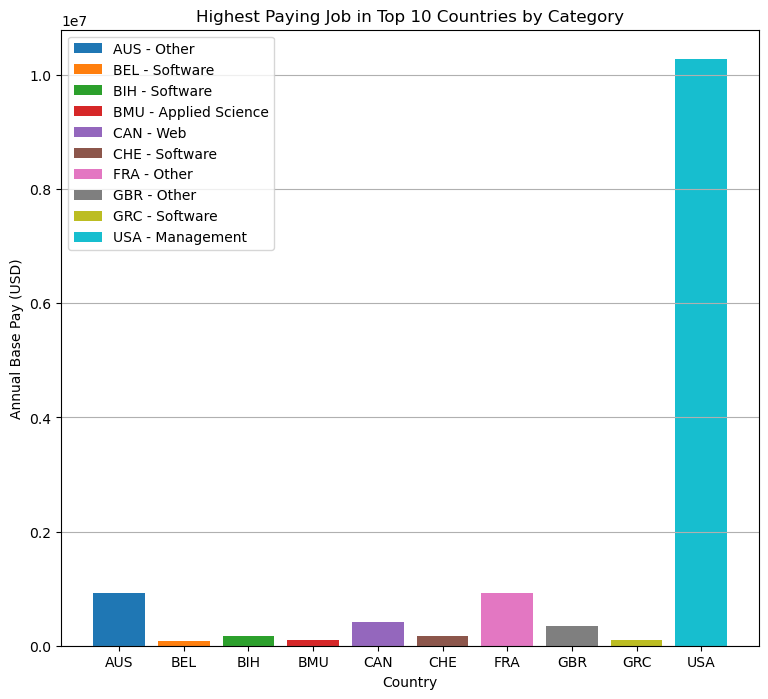

In [249]:
# Select top 
selected_countries = top_countries['location_country']
selected_countries_df = converted_cleaned_df[converted_cleaned_df['location_country'].isin(selected_countries)]

# Find the highest paying job category for each selected country
max_salary_idx = selected_countries_df.groupby(['location_country'])['annual_base_pay'].idxmax()
highest_paying_df = selected_countries_df.loc[max_salary_idx]

plt.figure(figsize=(9, 8))

for country, group in highest_paying_df.groupby('location_country'):
    plt.bar(country, group['annual_base_pay'].values[0], label=f'{country} - {group["job_title_category"].values[0]}')

# Customize the plot
plt.title('Highest Paying Job in Top 10 Countries by Category')
plt.xlabel('Country')
plt.ylabel('Annual Base Pay (USD)')
plt.legend()
plt.grid(axis='y')

plt.show()

The choice of creating a follow-up plot showcasing the category of the highest paying job in each of the top 10 countries with the highest average base salary adds a layer of complexity and nuance to the analysis. This variable is selected because it provides insights into the specific job categories that contribute significantly to high salaries in each country. Understanding the distribution of high-paying job categories allows for a more detailed examination of salary variations within the tech industry across different nations. 

From the graph, "software" and "other" are demonstrated to be the most common highest paying job category. The prevalence of "Software Engineer" as the most frequently occurring job title in the first summary statistics table and "software" being the highest paying job category in several countries underscore the global importance and high demand for software-related roles in the tech industry. Companies and countries recognizing the critical role of software in their technological landscape are likely to allocate higher compensation to professionals who possess expertise in this domain, resulting in the popularity of this category. Despite a substantial pool of available talent (high apply), the tech industry's continuous pursuit of innovation and the development of digital products contribute to the sustained demand for skilled software professionals. Interestingly, many countries' top paying job doesn't belong in any of 8 main categories. This could be contributed to the growing start-up, self-employment and freelancing community. I will explore this hypothesis more in a later graph detailing specific employers offering high annual base pay.

The highest paying job recorded the dataset is in the US, falling under the management category. It is worth noting that its annual base pay far surpasses any other jobs offered in other countries. This aligns with the discovery from the previous graph that employers in the US offers the high average base salary. The high annual base pay offered is undoubtedly an incentive for workers to seek employment in the US, resulting in the country being the most popular as seen in the second summary statistics table. Management as the highest paying job category implies a significant emphasis on leadership positions. This behaviour not seen in any other countries from this dataset, which could indicate that such positions in the US pay significantly higher compared to other countries and is a significant factor in raising the overall higher average base salary in the country. 

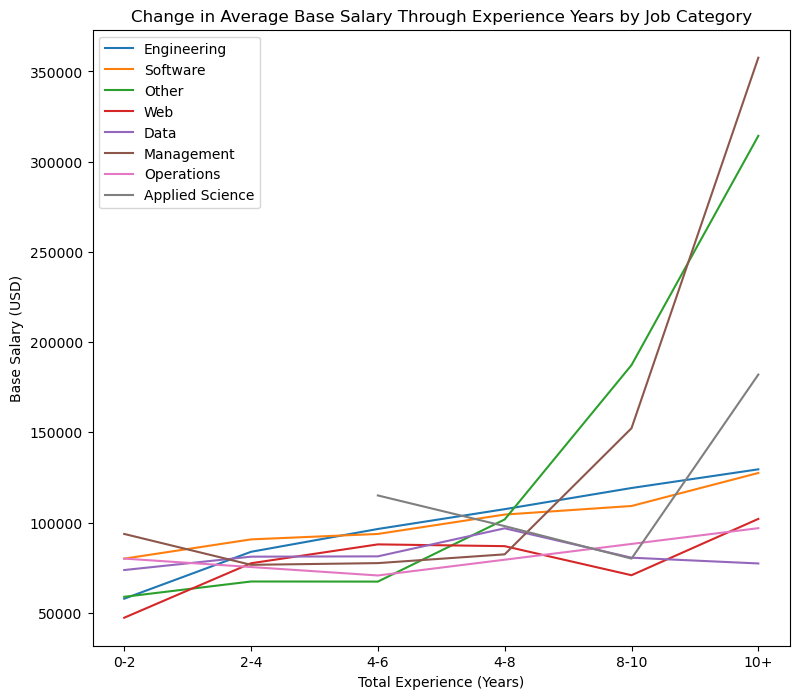

In [247]:
bins = [0, 2, 4, 6, 8, 10, float('inf')]
exp_grouped_df = converted_cleaned_df.copy()
exp_grouped_df['experience_group'] = pd.cut(converted_cleaned_df['total_experience_years'], bins=bins, labels=['0-2', '2-4', '4-6', '4-8', '8-10', '10+'])

avg_pay_grouped = exp_grouped_df.groupby(['job_title_category', 'experience_group'], observed=True)['annual_base_pay'].mean().reset_index()

plt.figure(figsize=(9, 8))

for job_category in df['job_title_category'].unique():
    job_data = avg_pay_grouped[avg_pay_grouped['job_title_category'] == job_category]
    plt.plot(job_data['experience_group'], job_data['annual_base_pay'], label=job_category)

# Customize the plot
plt.xlabel('Total Experience (Years)')
plt.ylabel('Base Salary (USD)')
plt.title('Change in Average Base Salary Through Experience Years by Job Category')
plt.legend()

plt.show()

Looking at salaries trend as employees gain experience, I would expect every category to trend upward as time goes on. However, there are some fields with significantly larger increases compared to others. Jobs in web and engineering experiences overall growth, while operations and data jobs appears to be rather stagnant in base pay, remaining in the high five figures throughout the years. Management has the highest unexperienced salary and experiences a significant increase after 8 years of total experience, ending up as the highest paying category when number total experience years is large. While the "other" category starts off with lower salaries early in the career, it experiences a similar boost as the management category after 8 years. This supports the results from the previous highest paying job graph. Freelancers or self-employed individuals are often unable to earn high salary at the beginning due to immense investment, but once successful, sees great return. 

Interestingly, despite software being the most popular and highest paying cateogry in many country, while base salary does increase steadily throughout the years, it is not significant compared to other fields. Despite it having the second highest entry-level salary, just after management, its salary doesn't depend heavily on experience. A reason behind this could be because the field of technology evolves rapidly, and in some cases, employees may reach a point where their skill set and experience have plateaued, and they are not acquiring new, in-demand skills. Due to this, this category values new talents, and they are attracted by its high starting salary, resulting in the high supply and demand in this category. 

Changes in average base salaries over experience years offer insights into broader industry dynamics. For example, highlights why certain job categories are popular and in high demand, influencing compensation trends. Furthermore, this graph investigates a potential influencing factor for annual base pay in the tech industry: experience. It offers insights into how experience influences salary, and which job categories exhibit more prominant salary growth with increased experience. From my analysis, it can be seen that experience plays a significant factor impact salary in categories such as management and other, and signficantly less so in operations and data. 

/Users/macychen/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 900x800 with 0 Axes>

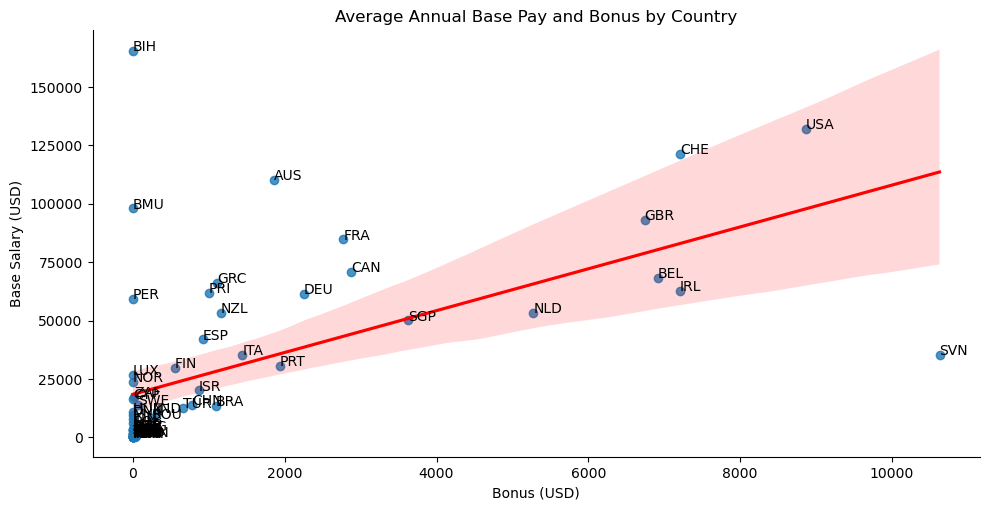

In [260]:
# Group by country and calculate the mean annual base pay and bonus
bonus_pay_df = converted_cleaned_df.groupby('location_country')[['annual_base_pay', 'annual_bonus']].mean().reset_index()

plt.figure(figsize=(9, 8), layout='constrained')

sns.lmplot(x='annual_bonus', y='annual_base_pay', data=bonus_pay_df, legend=False, aspect=2, line_kws={'color': 'red'})

for line in range(0,bonus_pay_df.shape[0]):
    plt.text(bonus_pay_df.annual_bonus[line], bonus_pay_df.annual_base_pay[line], bonus_pay_df.location_country[line], horizontalalignment='left')

plt.title('Average Annual Base Pay and Bonus by Country')

plt.xlabel('Bonus (USD)')
plt.ylabel('Base Salary (USD)')
plt.show()

This graph demonstrates the relationship between average annual bonus and average annual base pay, with each point representing a unique country. It provides a visual representation of the connection between these two variables, allowing for insights into how bonuses and base pay relate to each other on a global scale.

The observation of a general upward trend indicates that countries with higher average annual bonuses also tend to have higher average annual base pay. This correlation suggests that there may be a positive relationship between these two components of compensation. However, the presence of outliers, such as the Bosnia and Herzegovina with a high base pay but low bonus and Slovenia with lower base pay but high salary, indicates that there are exceptions to this trend.

The observation that a large number of countries with average base pay below 25,000 USD has an average annual bonus of 0 USD highlights an interesting aspect of the compensation structure. This graph highlighting a factor that contributes to the high standard deviation in annual bonus. The relatively low base pay and no bonus in these instances suggests that there isn't a compensatory mechanism through which high bonus is used to offset the lower base pay in the majority of countries. This insight becomes significant in understanding the dispersion in total wages between countries. The disparity in compensation between countries is a combination of significant differences in bonuses and base pay; while certain countries may have lower baseline salary structures, and the absence of bonuses exacerbates the wage discrepancy.

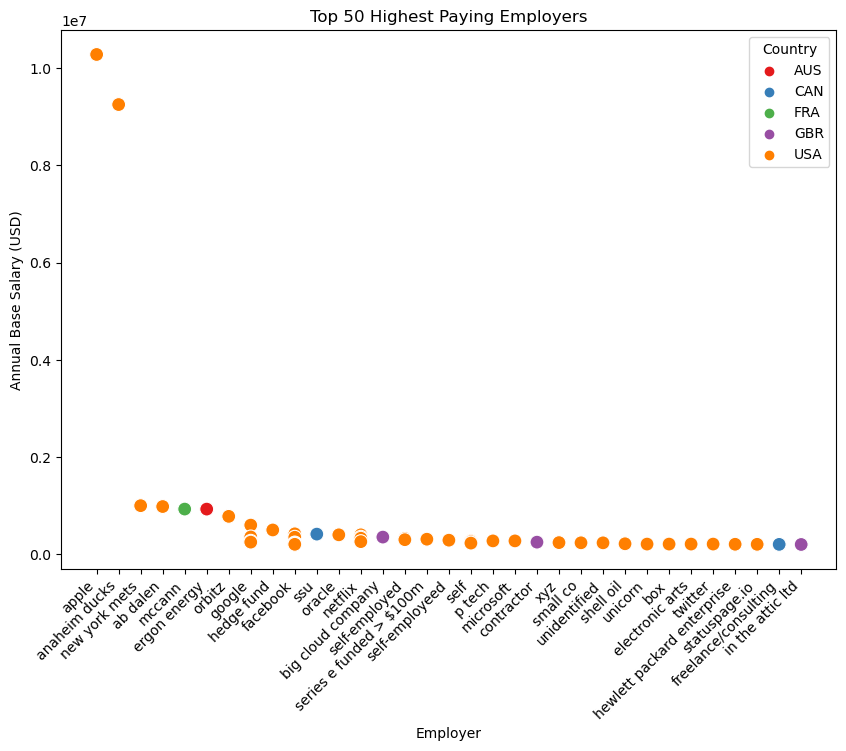

In [253]:
sorted_salary_df = converted_cleaned_df.sort_values(by='annual_base_pay', ascending=False).head(50)
top_employers = sorted_salary_df.copy()
top_employers['location_country'] = top_employers['location_country'].astype('category')

plt.figure(figsize=(10, 7))
sns.scatterplot(x='employer_name', y='annual_base_pay', hue='location_country', palette='Set1', s=100, data=top_employers)

plt.title('Top 50 Highest Paying Employers')
plt.xlabel('Employer')
plt.ylabel('Annual Base Salary (USD)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Country')

plt.show()

This graph shows the companies of the top 50 highest paying jobs and their corresponding locations. Some companies have multiple dots as multiple jobs from the this company made the top 50 in highest paying. Looking at the graph, it can be seen that the vast majority of highest paying employers are in the US. This is unsuprising as it supports previously seen evidence of US having the highest annual base pay in other graphs. Additionally, a few employers from Australia (AUS), France (FRA), Great Britain (GBR) and Canada (CAN) are in the top 50 as well, which is expected as the same countries appeared on the 'Top 10 Countries with Highest Base Salary' graph. 

Upon closer examination of specific employers, the consistent presence of large and recognized employers such as Apple, Microsoft, Oracle, and other industry leaders in different categories indicates that the reputation and size of the employer likely influence salary levels. Larger, more established companies do offer higher salaries, demonstrated by high annual base pay offered by multiple different offices of Google, Facebook and Netflix as seen on the graph. However, a few self-employed, start-up, and sport teams do make the list, such as the high placement of Anaheim Ducks and New York Mets, which supports my eariler hypothesis.

Examining the job categories of the top-paying employers can reveal that software-related companies do appear often on the list, for example Google, Netflix and Electronic Arts. This strengthens the connection between the popularity of software jobs and high compensation, corroborating the patterns observed in the job category-related graphs.

This graph serves as a source of information to answer my research question on whether employer stature is an influencing factor on annual base pay. It offers insights into global salary distribution in industry leaders and compensation practices among different types of employers. While the rise of self-employed and start-ups can seen, the dominating appearance of recognizable companies in the top 50 highest paying employers reflects that the size and nature of company does have an influence on annual pay to a certain extent, often correlating with higher salaries. 

# Project Two

## The Message

## Maps and Interpretations

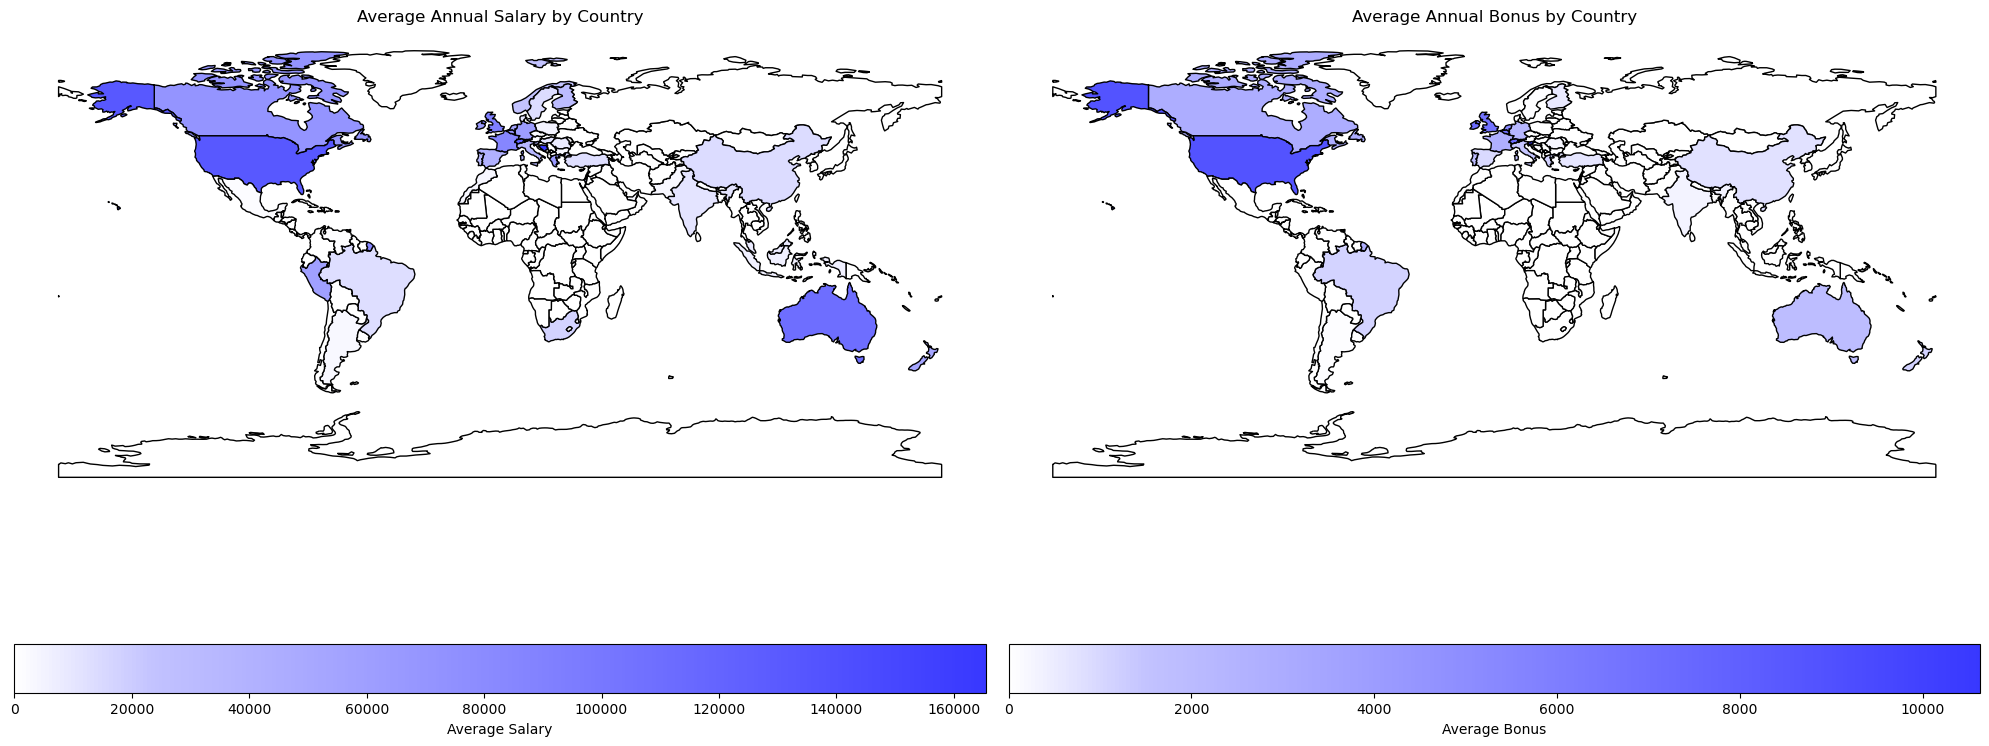

In [201]:
# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

countrymean_df = converted_cleaned_df.groupby('location_country')[['annual_base_pay', 'annual_bonus']].mean().reset_index()

# Read the file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Merge mean salary data with world shapefile
countrymean_gdf = world.merge(countrymean_df, how='left', left_on='iso_a3', right_on='location_country')

# Set NaN values to a default color (white)
countrymean_gdf['annual_base_pay'].fillna(0, inplace=True)
countrymean_gdf['annual_bonus'].fillna(0, inplace=True)

# Define custom colormap
colors = ['#FFFFFF', '#C2C2FF', '#ABABFF', '#9494FF', '#7D7DFF', '#6666FF', '#4F4FFF', '#3838FF']
cmap = LinearSegmentedColormap.from_list('custom_palette', colors)

# Plotting two maps side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Map 1: average annual salary by country
average_salary_plot = countrymean_gdf.plot(column='annual_base_pay', ax=ax[0], legend=True, edgecolor='black',
           legend_kwds={'label': "Average Salar (USD)",
                        'orientation': "horizontal"}, cmap=cmap)
ax[0].set_title('Average Annual Salary by Country')
ax[0].axis('off')

# Map 2: average annual bonus by country
average_bonus_plot = countrymean_gdf.plot(column='annual_bonus', ax=ax[1], legend=True, edgecolor='black',
           legend_kwds={'label': "Average Bonus (USD)",
                        'orientation': "horizontal"}, cmap=cmap)
ax[1].set_title('Average Annual Bonus by Country')
ax[1].axis('off')

plt.tight_layout()
plt.show()

### Merging with a New Dataset

The data is obtained from [Numbeo](https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2016&displayColumn=-1). This dataset includes details about the cost of living of countries in 2016, including information such as the cost of living index, rent index, cost of living and rent index, groceries index, restaurant index, and local purchasing power index. Incorporating a dataset on the cost of living index for various countries can help contextualize salary differentials. By comparing salary levels with the cost of living, I can assess the purchasing power and relative affordability of salaries in different locations. This can provide insights into how local economic conditions and standards of living reflect salary levels.

In [299]:
#load in dataset
COLIndex_df = pd.read_csv("~/ECO225/ECO225Project/Data/COL_index_2016.csv", low_memory=False)
COLIndex_df.head()

,location_country,cost_of_living_index,rent_index,cost_of_living_plus_rent_index,groceries_index,restaurant_index,local_purchasing_power_index
0,Bermuda,133.7,120.1,127.2,131.9,121.3,118.5
1,Switzerland,123.1,55.1,90.4,123.9,119.1,178.7
2,Bahamas,107.5,38.2,74.2,107.1,88.4,59.0
3,Norway,99.8,37.0,69.6,93.3,110.8,125.8
4,Iceland,96.5,35.4,67.1,91.4,98.8,94.0


In [300]:
# Function to map country names to ISO Alpha-3 codes
def get_country_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None

COLIndex_df['location_country'] = COLIndex_df['location_country'].apply(get_country_code)

In [301]:
# Merge cost of living index data with mean annual salary and bonus
merged_df = countrymean_df.merge(COLIndex_df, how='left', on='location_country')
merged_df['cost_of_living_index'].fillna(0, inplace=True)
merged_df.head()

,location_country,annual_base_pay,annual_bonus,cost_of_living_index,rent_index,cost_of_living_plus_rent_index,groceries_index,restaurant_index,local_purchasing_power_index
0,ARE,2995.316414,0.000000,66.1,68.3,67.1,57.2,59.8,136.4
1,ARG,2930.579154,60.983150,64.1,18.1,42.0,52.5,64.2,74.9
2,AUS,110204.621718,1863.197974,78.5,41.0,60.4,74.7,74.8,147.3
3,AUT,1549.665106,0.000000,66.6,26.2,47.2,61.7,62.6,120.5
4,BEL,68240.609860,6918.147796,75.4,31.4,54.3,67.2,82.9,106.7


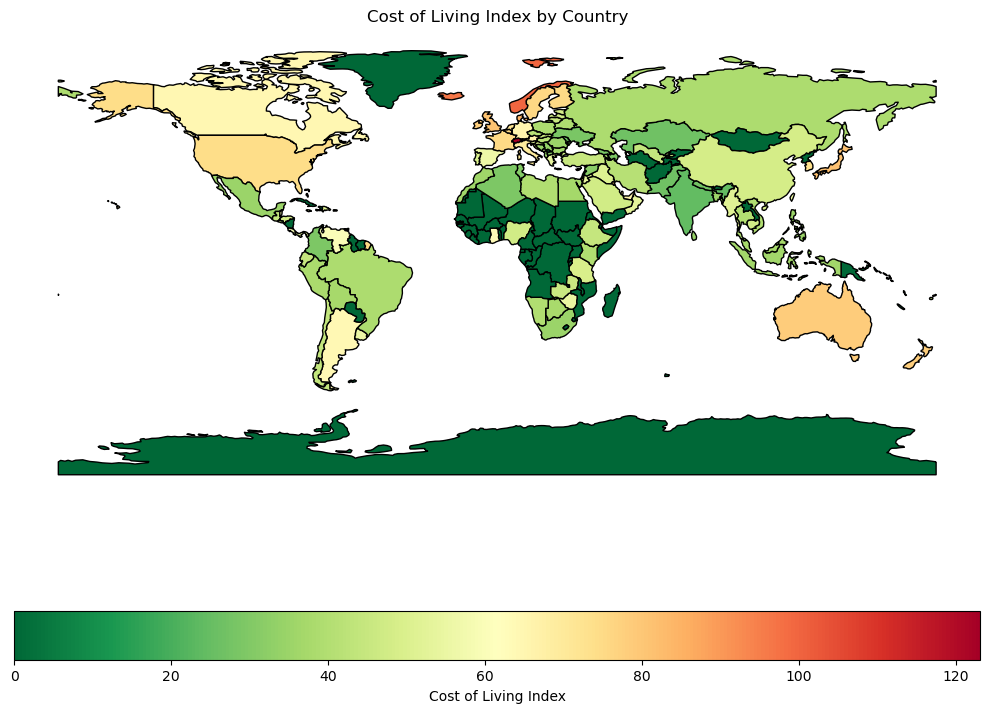

In [302]:
# Merge mean salary data with world shapefile
merged_gdf = world.merge(COLIndex_df, how='left', left_on='iso_a3', right_on='location_country')

merged_gdf['cost_of_living_index'].fillna(0, inplace=True)

# Plotting two maps side by side
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Map 1: average annual salary by country
merged_gdf.plot(column='cost_of_living_index', ax=ax, legend=True, edgecolor='black', 
                legend_kwds={'label': "Cost of Living Index",
                        'orientation': "horizontal"}, cmap='RdYlGn_r')
ax.set_title('Cost of Living Index by Country')
ax.axis('off')

plt.tight_layout()
plt.show()

/Users/macychen/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 900x600 with 0 Axes>

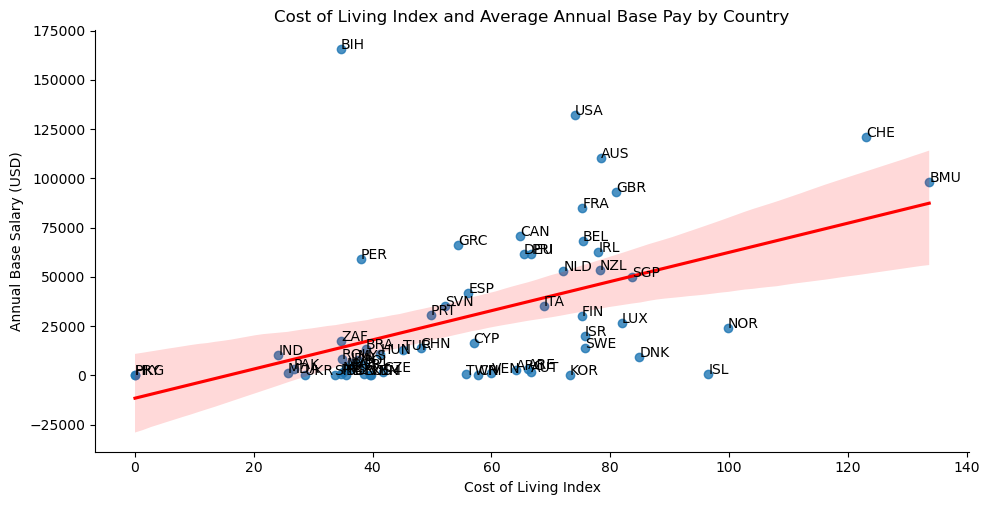

In [304]:
plt.figure(figsize=(9, 6), layout='constrained')

sns.lmplot(x='cost_of_living_index', y='annual_base_pay', data=merged_df, legend=False, aspect=2, line_kws={'color': 'red'})

for line in range(0,merged_df.shape[0]):
    plt.text(merged_df.cost_of_living_index[line], merged_df.annual_base_pay[line], merged_df.location_country[line], horizontalalignment='left')

plt.title('Cost of Living Index and Average Annual Base Pay by Country')

plt.xlabel('Cost of Living Index')
plt.ylabel('Annual Base Salary (USD)')
plt.show()

## Conclusion

In this study investigating salary variations in the global tech industry, my findings reveal nuanced insights into the factors influencing annual base pay. The analysis of the "Top 10 Countries with Highest Average Base Salary" illustrates a consistent dominance of the United States, emphasizing its pivotal role in shaping salary trends within the industry. The prevalence of software-related roles, highlighted in both job titles and highest paying job categories, underscores the global demand for expertise in this domain. Furthermore, the examination of the "Change in Average Base Salary Through Experience Years by Job Category" provides a detailed understanding of how base pay evolves significantly with increasing experience for categories such as management and other, while has minimal impact on operations and data jobs. 

The exploration of the "Top 50 Highest Paying Employers" adds a layer of complexity to the narrative, showcasing the industry leaders in terms of annual base salary. Notably, Google, Facebook and Netflix emerge as recurrent entities, signifying the prominent positions of large employers in providing competitive salaries. The inclusion of companies from Switzerland, France, Canada, and Great Britain reflects the findings in "Top 10 Countries with Highest Average Base Salary". By combining the results regarding the 'other' categories from all graphs, it can be seen that freelancers, self-employed and employees working at non-FAANG companies are also able to earn high annual base pay later in their careers. Salary in this category starting off on the lower end but experiences expotential growth through the years, making them one of the highest paying categories after 8 years of experience. 


The large number of countries with no bonuses and lower base pay found in the 'Average Annual Base Pay and Bonus Grouped by Country' graph emphasizes the diversity in global compensation practices. This dispersion in total wages between countries underscores the need for a nuanced understanding of economic and labor market dynamics, as well as potential disparities in living standards and costs of living that contribute to variations in compensation structures worldwide.

These findings collectively contribute to a comprehensive understanding of the intricate dynamics influencing salary variations in the tech industry. Future research endeavors should delve deeper into cultural and economic factors influencing base pay across diverse geographical contexts. Additionally, comparative analyses with similar studies in the field using larger datasets will verify the integrity, offer a broader perspective and contribute to the insights found on tech industry salaries in this study.